In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [992]:
K = 2
N = 100
sigma = 0.01

alpha = 0.5 * jnp.ones(K,)

In [1014]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.68387323 0.31612677]
1.0


In [1016]:
pi = jnp.array([0.68387323, 0.31612677])

In [1080]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.64
0.36


In [1081]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[ 0.83237467 -0.31148312]


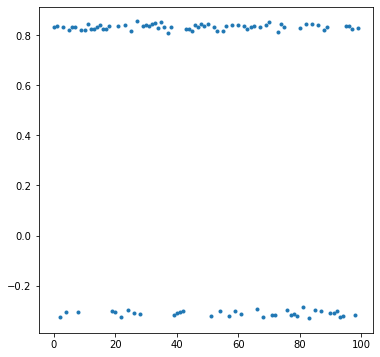

In [1082]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

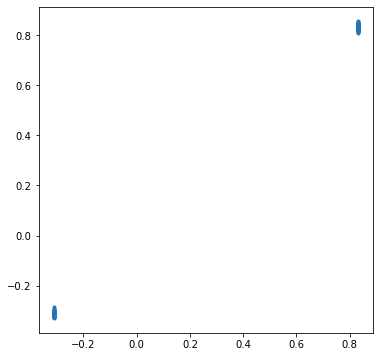

In [1083]:
plt.plot(x[z], y, '.')

In [1084]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [1085]:
calc_nik_jit(z).shape

(100, 2)

In [1086]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

63
36
0


In [1087]:
calc_nik_jit(z).shape

(100, 2)

In [1088]:
pi

DeviceArray([0.68387323, 0.31612677], dtype=float64)

In [1333]:
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize
    for k in jnp.arange(K):
        log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*(n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        #log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*pi[k]
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    #print(logPZalpha)
    print("term A ", jnp.sum(jnp.log(log_arg)) )
    #print("term B ", - jnp.sum(x**2))
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) + logPZalpha

In [1334]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [1335]:
probs_d = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
probs_d = jnp.array(probs_d).transpose()   


In [1336]:
pi

DeviceArray([0.68387323, 0.31612677], dtype=float64)

In [1337]:
probs_d

DeviceArray([[0.635, 0.365],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.645, 0.355],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [0.635, 0.365],
             [

In [1338]:
jnp.sum(probs_d, axis=1)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64)

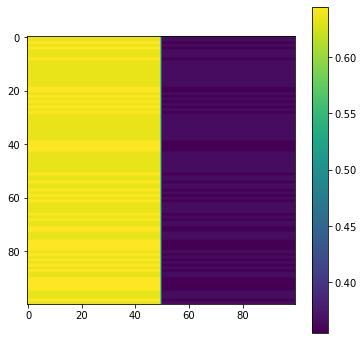

In [1339]:
plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [1340]:
n_ik_z.shape

(100, 2)

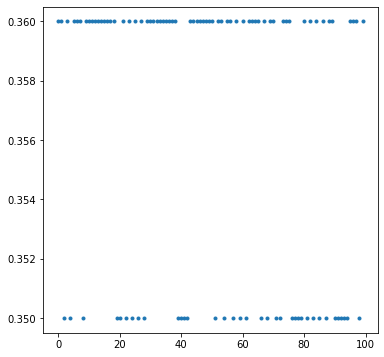

In [1341]:
plt.plot(n_ik_z[:,4]/N,'.')

In [1342]:
logPi(x, z, y, sigma, alpha)

term A  63.610495663401224


DeviceArray(-3.90748142, dtype=float64)

In [1343]:
pi

DeviceArray([0.68387323, 0.31612677], dtype=float64)

In [1345]:
key, subkey = random.split(key)
z0 = random.randint(subkey, z.shape, 0, K)
#z0 = jnp.ones(z.shape)
z0 = z
(logPi(jnp.array([x[0], x[1]]), z0, y, sigma, alpha))
(logPi(jnp.array([x[1], x[1]]), z0, y, sigma, alpha))
(logPi(jnp.array([x[0], x[0]]), z0, y, sigma, alpha))
(logPi(jnp.array([x[1], x[0]]), z0, y, sigma, alpha))


term A  63.610495663401224
term A  35.57620348512157
term A  63.40059983667809
term A  57.29448984534504


DeviceArray(-10.22348723, dtype=float64)

In [1197]:
z_correct = z

In [1161]:
@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0
     

### First, sample x

In [1100]:
print(pi)
print(x)

[0.68387323 0.31612677]
[ 0.83237467 -0.31148312]


In [1101]:
x**2

DeviceArray([0.69284759, 0.09702174], dtype=float64)

  MCMC sample 1000, loss = 11.363832913635626, a = 1.0223177471654394e-27
  MCMC sample 2000, loss = 11.363832913635626, a = 2.564281653675782e-24
  MCMC sample 3000, loss = 11.363832913635626, a = 2.65735178613941e-29
  MCMC sample 4000, loss = 5.511798136941508, a = 1.6955366534411326e-28
  MCMC sample 5000, loss = 5.511798136941508, a = 2.6305161979083666e-29
  MCMC sample 6000, loss = 5.511798136941508, a = 9.739549071415232e-30
  MCMC sample 7000, loss = 5.511798136941508, a = 7.141652311292632e-29
  MCMC sample 8000, loss = 5.511798136941508, a = 4.205622662248149e-27
  MCMC sample 9000, loss = 5.511798136941508, a = 5.8552383627474455e-31
[-1.29905883 -0.06564757]
[ 0.84725509 -0.32253892]
[ 0.83237467 -0.31148312]


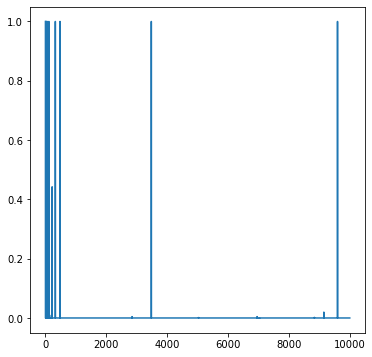

In [1103]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


  MCMC sample 1000, loss = 4.1793302071812235, a = 2.1774088721039157e-23
  MCMC sample 2000, loss = 4.017059718265479, a = 9.784371553050716e-21
  MCMC sample 3000, loss = 4.072765915623556, a = 3.7300342426544335e-24
  MCMC sample 4000, loss = 3.951993225689087, a = 6.013750318609666e-24
  MCMC sample 5000, loss = 3.952113075867757, a = 5.558944413184357e-22
  MCMC sample 6000, loss = 3.935899149597958, a = 2.3616323502732026e-23
  MCMC sample 7000, loss = 4.4461359865132835, a = 1.7829346201942118e-20
  MCMC sample 8000, loss = 4.928465803638673, a = 1.71726297285567e-20
  MCMC sample 9000, loss = 3.9740643920014804, a = 1.0138085292650128e-21
  MCMC sample 10000, loss = 4.962471746908605, a = 2.844927425254973e-20
0.24609013664283474
0.846589173483991
[ 0.83237467 -0.31148312]


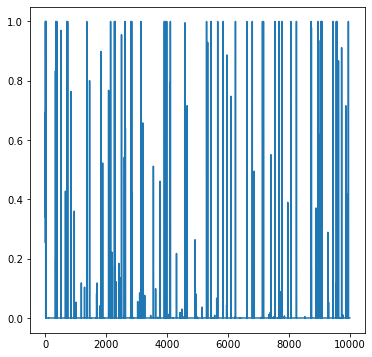

In [1106]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

  MCMC sample 1000, loss = 3.8979487302045683, a = 1.0
  MCMC sample 2000, loss = 6.369009954314862, a = 6.319941953064741e-08
  MCMC sample 3000, loss = 3.8997058420986477, a = 1.6326199056891663e-11
  MCMC sample 4000, loss = 4.905371193625889, a = 3.96727399913411e-11
  MCMC sample 5000, loss = 5.3621789406683575, a = 6.511055324208658e-08
  MCMC sample 6000, loss = 4.253959898908292, a = 0.029179163781378095
  MCMC sample 7000, loss = 4.002859105667788, a = 7.724189192215492e-08
  MCMC sample 8000, loss = 6.274949649559076, a = 2.2600917339783188e-07
  MCMC sample 9000, loss = 4.715978833290691, a = 1.7949987405388905e-09
  MCMC sample 10000, loss = 6.091428149426882, a = 0.26413078504989995
0.69580036893882
0.806477676219028
[ 0.83237467 -0.31148312]


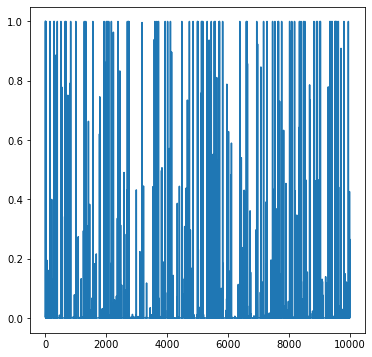

In [1111]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [1112]:
logPi(x, z, y, sigma, alpha)


term A  63.610495663401224
term B  -0.7898693217929046


DeviceArray(-3.90748142, dtype=float64)

In [1113]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

term A  63.610495663401224
term B  -0.7898693217929046


DeviceArray(-3.90748142, dtype=float64)

In [1114]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

term A  35.57620348512157
term B  -0.19404347235115288


DeviceArray(-31.34594774, dtype=float64)

In [1115]:
x

DeviceArray([ 0.83237467, -0.31148312], dtype=float64)

In [1125]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [1126]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

term A  Traced<ShapedArray(float64[])>with<BatchTrace(level=2/1)> with
  val = Traced<ShapedArray(float64[1000])>with<BatchTrace(level=1/1)> with
    val = Traced<ShapedArray(float64[1000,1000])>with<DynamicJaxprTrace(level=0/1)>
    batch_dim = 0
  batch_dim = 0
term B  Traced<ShapedArray(float64[])>with<BatchTrace(level=2/1)> with
  val = Traced<ShapedArray(float64[1000])>with<BatchTrace(level=1/1)> with
    val = Traced<ShapedArray(float64[1000,1000])>with<DynamicJaxprTrace(level=0/1)>
    batch_dim = 0
  batch_dim = 0


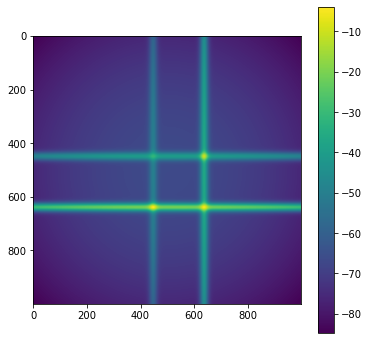

In [1127]:
plt.imshow((myf_xy)); plt.colorbar()

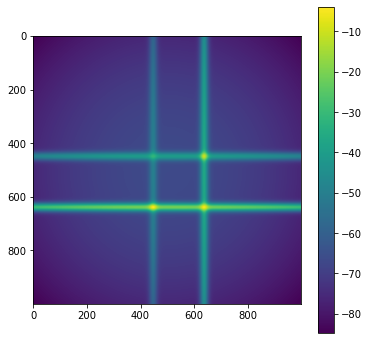

In [1128]:
plt.imshow((myf_xy)); plt.colorbar()

In [1129]:
jnp.log(8) + jnp.log(4)

DeviceArray(3.4657359, dtype=float64)

In [1130]:
#plt.imshow(jnp.abs(myf_xy0-myf_xy2)); plt.colorbar()

In [1131]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

term A  63.610495663401224
term B  -0.7898693217929046
01 -3.9074814158273057
term A  63.40059983667809
term B  -1.3856951712346564
00 -4.713203091992192
term A  35.57620348512157
term B  -0.19404347235115288
11 -31.34594774466521
term A  57.29448984534504
term B  -0.7898693217929046
10 -10.223487233883489


In [1132]:
myf(x[0],x[1])

term A  63.610495663401224
term B  -0.7898693217929046


DeviceArray(-3.90748142, dtype=float64)

In [1133]:
jnp.max(myf_xy)

DeviceArray(-3.89811366, dtype=float64)

### Now sample z

In [323]:
z.shape

(100,)

term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term B  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term B  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term B  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term B  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
  MCMC sample 1000, loss = 2.787741280247289, a = 0.0013792301707712304
  MCMC sample 2000, loss = 1.9303071443641926, a = 9.755266655874516e-05
  MCMC sample 3000, loss = 9.35649551384158, a = 0.3026813968527841
  MCMC sample 4000, loss = 4.868105862543999, a = 0.006604839635675252
  MCMC sample 5000, loss = 1.9123865154714537, a = 0.0006415190361425648
  MCMC sample 6000, loss = 2.713275935719693, a = 0.0004329

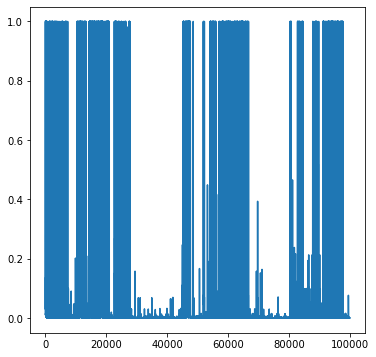

In [1134]:
N_samples_z = 100001
z0 = jnp.array(np.random.randint(0, K, (N,)))
B = 3

params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


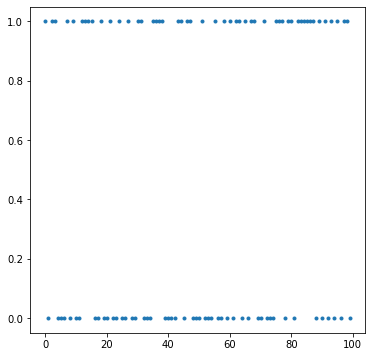

In [1135]:
plt.plot(jnp.abs(z0-z), '.')


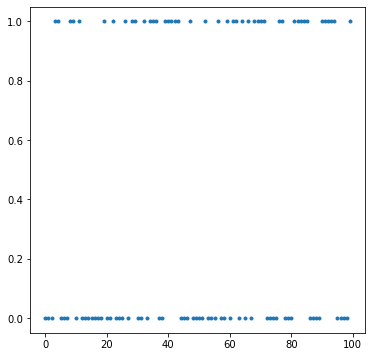

In [1136]:
plt.plot(jnp.abs(z_rec-z), '.')

In [1137]:
z

DeviceArray([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
             1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
             1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
             0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
             0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],            dtype=int64)

In [1138]:
z_rec

DeviceArray([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
             1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
             0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
             0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
             0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],            dtype=int64)

In [1139]:
pi

DeviceArray([0.68387323, 0.31612677], dtype=float64)

In [1140]:
x

DeviceArray([ 0.83237467, -0.31148312], dtype=float64)